# Koopman kernel models for TC Tracks

This notebook gives an introduction in the application of Koopman kernel models for tropical cyclone track prediction. We consider the translation between the default kooplearn and climada data structures and explain the data preprocessing steps which are required before model training. After this we compare several Koopman kernel models.

## Working with context windows

Below we construct context windows (the default kooplearn datastructure) from CLIMADA tropical cyclone tracks.

In [ ]:
from klearn_tcyclone.climada.tc_tracks import TCTracks
from matplotlib import pyplot as plt
import numpy as np

from klearn_tcyclone.data_utils import data_array_list_from_TCTracks, context_dataset_from_TCTracks, characteristic_length_scale_from_TCTracks

from sklearn.model_selection import train_test_split
from kooplearn.models import Kernel, NystroemKernel
from sklearn.gaussian_process.kernels import RBF
from klearn_tcyclone.data_utils import standardize_TensorContextDataset, LinearScaler

from klearn_tcyclone.climada.tc_tracks_tools import BASINS_ALL
import cartopy.crs as ccrs
import climada.util.plot as u_plot

from klearn_tcyclone.utils import check_time_steps_TCTracks

In [ ]:
BASINS_ALL

['EP', 'NA', 'NI', 'SI', 'SP', 'WP', 'SA']

We first investigate the kooplearn context window data structure and build some tools to translate CLIMADA's TCTracks data into context windows.

For now we just load some cyclone tracks from the East Pacific ("EP") in the years 2000 and 2001.

In [3]:
tc_tracks = TCTracks.from_ibtracs_netcdf(provider='usa', year_range=(2000, 2001), basin='EP', correct_pres=False)
print('Number of tracks:', tc_tracks.size)

2025-01-05 14:39:31,586 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /home/ecjb/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2025-01-05 14:39:39,266 - climada.hazard.tc_tracks - WARNING - 8 storm events are discarded because no valid wind/pressure values have been found: 2000138N16119, 2000187N12245, 2000201N11224, 2000203N17249, 2000209N06182, ...


/home/ecjb/packages/climada_python/climada/hazard/tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


Number of tracks: 36


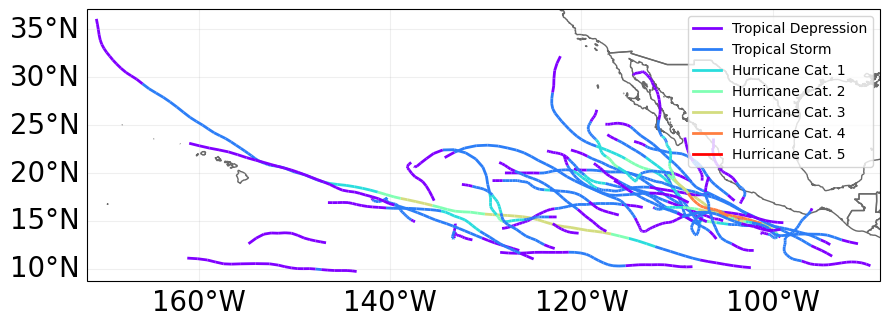

In [4]:
ax = tc_tracks.plot()

In [5]:
feature_list = ["lat", "lon", "max_sustained_wind", "central_pressure"]

In [6]:
data_array_list = data_array_list_from_TCTracks(tc_tracks=tc_tracks, feature_list=feature_list)

The context length defines the length of the trajectories in the context training dataset (axis 1 in the data array).

In [13]:
context_length = 12

tensor_context_dataset = context_dataset_from_TCTracks(
    tc_tracks, feature_list=feature_list, context_length=context_length
)
tensor_context_dataset.shape

(1068, 12, 4)

In [14]:
tensor_context_dataset[0]

TensorContextDataset <item_count=1, context_length=12, data=[[[  13.30000019  -99.19999695   25.         1005.        ]
  [  13.62234306  -99.72260284   27.         1004.        ]
  [  13.89999962 -100.19999695   30.         1004.        ]
  [  14.12994671 -100.67256927   30.         1003.        ]
  [  14.30000019 -101.09999847   30.         1003.        ]
  [  14.42987347 -101.465065     32.         1002.        ]
  [  14.5        -101.80000305   35.         1002.        ]
  [  14.51498032 -102.15757751   37.         1001.        ]
  [  14.5        -102.5          40.         1001.        ]
  [  14.49243164 -102.80753326   42.         1000.        ]
  [  14.5        -103.09999847   45.         1000.        ]
  [  14.54996109 -103.39995575   47.          998.        ]]]>

In [15]:
tensor_context_dataset[0].lookback(3), tensor_context_dataset[0].lookforward(3)

(array([[[  13.30000019,  -99.19999695,   25.        , 1005.        ],
         [  13.62234306,  -99.72260284,   27.        , 1004.        ],
         [  13.89999962, -100.19999695,   30.        , 1004.        ]]]),
 array([[[  14.12994671, -100.67256927,   30.        , 1003.        ],
         [  14.30000019, -101.09999847,   30.        , 1003.        ],
         [  14.42987347, -101.465065  ,   32.        , 1002.        ],
         [  14.5       , -101.80000305,   35.        , 1002.        ],
         [  14.51498032, -102.15757751,   37.        , 1001.        ],
         [  14.5       , -102.5       ,   40.        , 1001.        ],
         [  14.49243164, -102.80753326,   42.        , 1000.        ],
         [  14.5       , -103.09999847,   45.        , 1000.        ],
         [  14.54996109, -103.39995575,   47.        ,  998.        ]]]))

Everything seems to work.

## Get data and preprocess

BASIN_ENV_PRESSURE = {
    '': DEF_ENV_PRESSURE,
    'EP': 1010, 'NA': 1010, 'SA': 1010,
    'NI': 1005, 'SI': 1005, 'WP': 1005,
    'SP': 1004,
}

In [25]:
tc_tracks = TCTracks.from_ibtracs_netcdf(provider='usa', year_range=(2000, 2021), basin='NA', correct_pres=False)
print('Number of tracks:', tc_tracks.size)

2025-01-05 14:44:17,257 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /home/ecjb/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


/home/ecjb/packages/climada_python/climada/hazard/tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


Number of tracks: 393


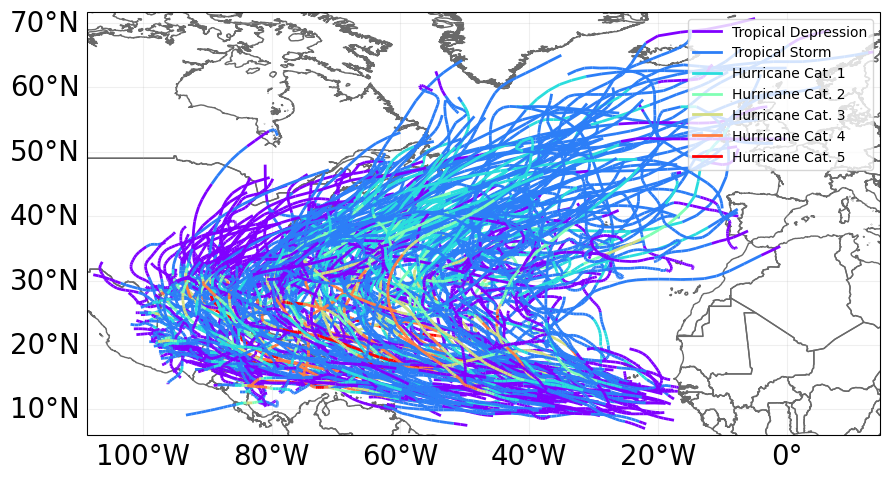

In [17]:
ax = tc_tracks.plot()

The first step is to ensure that all cyclone tracks are sampled with the same time step. This is done with the method `.equal_timestep()`. Missing values are obtained by interpolation.

In [28]:
time_step_h = 3
tc_tracks.equal_timestep(time_step_h=time_step_h)
check_time_steps_TCTracks(tc_tracks, time_step_h=time_step_h)

np.True_

For most of the model training done in this project, we use a `time_step_h = 1`. This ensures sufficiently long trajectories and a sufficient amount of data for model training.

#### Save tropical cyclone plot

We focus on two basins (East Pacific and North Atlantic) and save an exemplary plot.

In [29]:
tc_tracks_EP = TCTracks.from_ibtracs_netcdf(provider="official", year_range=(2000, 2005), basin="EP", correct_pres=False)
tc_tracks_NA = TCTracks.from_ibtracs_netcdf(provider="official", year_range=(2000, 2005), basin="NA", correct_pres=False)

2025-01-05 14:46:40,401 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /home/ecjb/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2025-01-05 14:48:55,698 - climada.hazard.tc_tracks - WARNING - 4 storm events are discarded because no valid wind/pressure values have been found: 2000187N12245, 2000201N11224, 2000203N17249, 2000228N31180.


/home/ecjb/packages/climada_python/climada/hazard/tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


2025-01-05 14:48:56,819 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /home/ecjb/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


/home/ecjb/packages/climada_python/climada/hazard/tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


Text(0.5, 1.0, 'Basin: North Atlantic (NA)')

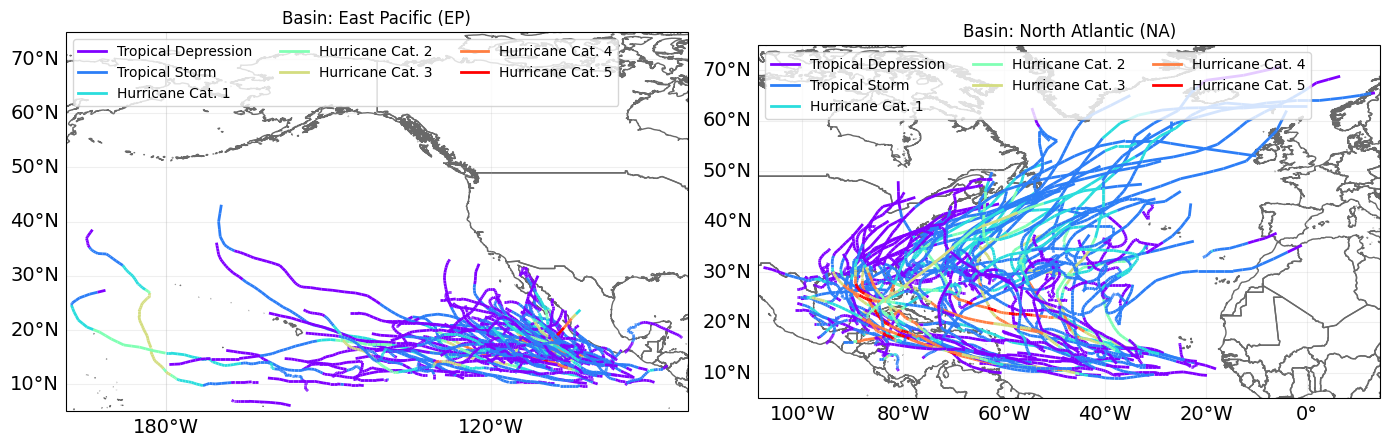

In [30]:
# figsize=(9, 13)
figsize=(14, 8)
adapt_fontsize=True
max_lat = 75
min_lat = 5
extent = tc_tracks_EP.get_extent(deg_buffer=1)
mid_lon = 0.5 * (extent[1] + extent[0])
proj = ccrs.PlateCarree(central_longitude=mid_lon)

fig, ax, _ = u_plot.make_map(
    num_sub=(1,2),
    proj=proj, figsize=figsize, adapt_fontsize=adapt_fontsize
)

extent = tc_tracks_EP.get_extent(deg_buffer=1)
extent = (*extent[:2], min_lat, max_lat)
_ = tc_tracks_EP.plot(
    axis=ax[0],
    figsize=figsize,
    legend=True,
    adapt_fontsize=adapt_fontsize,
    linestyle=None,
    extent=extent,
    loc_legend = 2,
    ncols_legend = 3,
)

extent = tc_tracks_NA.get_extent(deg_buffer=1)
extent = (*extent[:2], min_lat, max_lat)
_ = tc_tracks_NA.plot(
    axis=ax[1],
    figsize=figsize,
    legend=True,
    adapt_fontsize=adapt_fontsize,
    linestyle=None,
    extent=extent,
    loc_legend = 2,
    ncols_legend = 3,
)

ax[0].set_title("Basin: East Pacific (EP)")
ax[1].set_title("Basin: North Atlantic (NA)")

# save_path = os.path.join(
#     "../plots/", "tropical_cyclone_data/"
# )
# os.makedirs(save_path, exist_ok=True)
# fig.savefig(os.path.join(save_path, "TCTrack_EP_NA.png"), bbox_inches='tight')

#### Data standardization

In [31]:
tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)

context_length = 42
feature_list = ["lat", "lon", "max_sustained_wind"]
# feature_list = ["lat", "lon", "max_sustained_wind", "central_pressure"]
tensor_context_train = context_dataset_from_TCTracks(
    tc_tracks_train, feature_list=feature_list, context_length=context_length
)
tensor_context_test = context_dataset_from_TCTracks(
    tc_tracks_test, feature_list=feature_list, context_length=context_length
)

contexts = {
    "train": tensor_context_train,
    "test": tensor_context_test,
}

In [32]:
# scaler = StandardScaler()
scaler = LinearScaler()
# scaler = MinMaxScaler()
tensor_context_train_transformed = standardize_TensorContextDataset(
    tensor_context_train,
    scaler,
    fit=True,
)
tensor_context_test_transformed = standardize_TensorContextDataset(
    tensor_context_test,
    scaler,
    fit=False,
)

contexts = {
    "train": tensor_context_train_transformed,
    "test": tensor_context_test_transformed,
}

for split, ds in contexts.items():
    print(f"{split.capitalize()} contexts have shape {ds.shape}: {len(ds)} contexts of length {ds.context_length} with {ds.shape[2]} features each")

Train contexts have shape (8170, 42, 3): 8170 contexts of length 42 with 3 features each
Test contexts have shape (722, 42, 3): 722 contexts of length 42 with 3 features each


In [33]:
training_data_size = contexts["train"].shape[0]
training_data_size

8170

In [34]:
contexts["train"].shape

(8170, 42, 3)

In [35]:
contexts["train"][:12].shape

(12, 42, 3)

## Train and compare several Koopman kernel models

Training and evaluation of the kernel model is implemented in the ModelBenchmark class. We compare three different kernel models: "RRR", "Randomized-RRR" and "Nystroem-RRR".

In [1]:
from klearn_tcyclone.climada.tc_tracks import TCTracks
from klearn_tcyclone.klearn_tcyclone import ModelBenchmark
from klearn_tcyclone.KNF.modules.eval_metrics import (
    RMSE_OneStep_TCTracks,
)
eval_metric = RMSE_OneStep_TCTracks
import numpy as np
from sklearn.model_selection import train_test_split
from klearn_tcyclone.data_utils import characteristic_length_scale_from_TCTracks


from matplotlib import pyplot as plt

from kooplearn.models import Kernel, NystroemKernel
from sklearn.gaussian_process.kernels import RBF
from klearn_tcyclone.data_utils import LinearScaler

Focus on the North Atlantic (NA) basin in the following.

In [2]:
basin = "NA" 

In [3]:
tc_tracks = TCTracks.from_ibtracs_netcdf(provider='usa', year_range=(2000, 2021), basin=basin, correct_pres=False)
print('Number of tracks:', tc_tracks.size)

tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)
context_length = 42
feature_list = ["lat", "lon"]
scaler = LinearScaler()


reduced_rank = True
rank = 25
num_centers = 250
tikhonov_reg = 1e-6

# Instantiang the RBF kernel and its length scale as the median of the pairwise distances of the dataset
length_scale = characteristic_length_scale_from_TCTracks(tc_tracks_train, feature_list, quantile=0.2)
length_scale = 50.0
print("Length scale:", length_scale)
kernel = RBF(length_scale=length_scale)

models = {
    'RRR': Kernel(kernel=kernel, reduced_rank=reduced_rank, tikhonov_reg=tikhonov_reg, rank = rank, svd_solver='arnoldi'),
    'Randomized-RRR': Kernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='randomized', tikhonov_reg=tikhonov_reg, rank = rank, rng_seed=42),
    'Nystroem-RRR': NystroemKernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='arnoldi', tikhonov_reg=tikhonov_reg, rank = rank, num_centers=num_centers, rng_seed=42),
}

2025-01-05 15:06:48,828 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /home/ecjb/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


/home/ecjb/packages/climada_python/climada/hazard/tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


Number of tracks: 393
Length scale: 50.0


In [4]:
# train_stops = np.logspace(2.5, 2.9, 5).astype(int)
train_stops = np.logspace(2.5, 3.9, 5).astype(int)
train_stops

array([ 316,  707, 1584, 3548, 7943])

In [5]:
model_benchmarks = {
    name: ModelBenchmark(
        features=feature_list,
        tc_tracks_train=tc_tracks_train,
        tc_tracks_test=tc_tracks_test,
        basin=basin,
        scaler=scaler,
        context_length=context_length,
    )
    for name in models.keys()
}

In [6]:
print([mb.get_info() for mb in model_benchmarks.values()])

Train contexts have shape (8158, 42, 2): 8158 contexts of length 42 with 2 features each.
Test contexts have shape (937, 42, 2): 937 contexts of length 42 with 2 features each.
Train contexts have shape (8158, 42, 2): 8158 contexts of length 42 with 2 features each.
Test contexts have shape (937, 42, 2): 937 contexts of length 42 with 2 features each.
Train contexts have shape (8158, 42, 2): 8158 contexts of length 42 with 2 features each.
Test contexts have shape (937, 42, 2): 937 contexts of length 42 with 2 features each.
[None, None, None]


In [7]:
results = {
    name: mb.train_model(
        model=models[name],
        eval_metric=eval_metric,
        train_stops=train_stops,
    )
    for name, mb in model_benchmarks.items()
}


Model training: Training points: 316
Fitting of model took 0.20s with train RMSE of 0.02524 and test RMSE of 0.02458.

Model training: Training points: 707


Fitting of model took 3.17s with train RMSE of 0.02023 and test RMSE of 0.01812.

Model training: Training points: 1584


Fitting of model took 5.93s with train RMSE of 0.02105 and test RMSE of 0.01901.

Model training: Training points: 3548


Fitting of model took 6.60s with train RMSE of 0.02081 and test RMSE of 0.01849.

Model training: Training points: 7943


Fitting of model took 24.45s with train RMSE of 0.01930 and test RMSE of 0.01747.

Model training: Training points: 316
Fitting of model took 0.28s with train RMSE of 0.02524 and test RMSE of 0.02458.

Model training: Training points: 707
Fitting of model took 0.35s with train RMSE of 0.02023 and test RMSE of 0.01812.

Model training: Training points: 1584
Fitting of model took 1.10s with train RMSE of 0.02105 and test RMSE of 0.01901.

Model training: Training points: 3548
Fitting of model took 2.02s with train RMSE of 0.02081 and test RMSE of 0.01849.

Model training: Training points: 7943
Fitting of model took 12.67s with train RMSE of 0.01930 and test RMSE of 0.01747.

Model training: Training points: 316


The rank attribute has been updated to 10.
Consider decreasing the rank parameter.


Fitting of model took 2.06s with train RMSE of 0.05219 and test RMSE of 0.04729.

Model training: Training points: 707


The rank attribute has been updated to 8.
Consider decreasing the rank parameter.


Fitting of model took 2.02s with train RMSE of 0.04394 and test RMSE of 0.03987.

Model training: Training points: 1584


Fitting of model took 3.25s with train RMSE of 0.04593 and test RMSE of 0.04108.

Model training: Training points: 3548


Fitting of model took 1.49s with train RMSE of 0.04400 and test RMSE of 0.03948.

Model training: Training points: 7943


Fitting of model took 4.72s with train RMSE of 0.04178 and test RMSE of 0.03740.


Add RMSE to results dictionary.

In [8]:
for name in models.keys():
    for res in results[name]:
        res["RMSE_onestep_train_error"] = eval_metric(
            res["X_pred_train"], res["X_true_train"]
        )
        res["RMSE_onestep_test_error"] = eval_metric(
            res["X_pred_test"], res["X_true_test"]
        )

In [9]:
timings = {name: np.array([res["fit_time"] for res in results[name]]) for name in models.keys()}
RMSE_onestep_train_errors = {name: np.array([res["RMSE_onestep_train_error"] for res in results[name]]) for name in models.keys()}
RMSE_onestep_test_errors = {name: np.array([res["RMSE_onestep_test_error"] for res in results[name]]) for name in models.keys()}
speedup_train = {name: timings["RRR"]/timings[name] for name in models.keys()}
# speedup_train = {name: timings["Randomized-RRR"]/timings[name] for name in models.keys()}

Average fitting time speed-up for RRR: 1.00x
Average fitting time speed-up for Randomized-RRR: 4.07x
Average fitting time speed-up for Nystroem-RRR: 2.62x


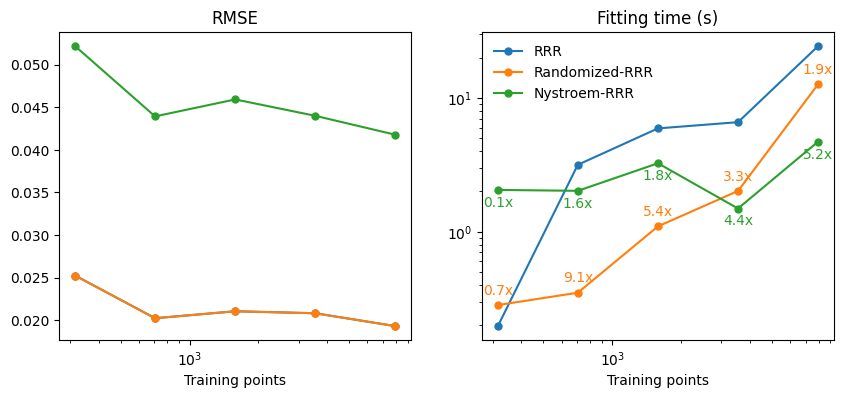

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for name in models.keys():
    axes[0].plot(train_stops, RMSE_onestep_train_errors[name],'.-', label=name, markersize=10)
    axes[1].plot(train_stops, timings[name],'.-', label=name, markersize=10)

colors = []
for line in axes[0].get_lines():
    colors.append(line.get_color())

axes[0].set_title('RMSE')
axes[1].set_title('Fitting time (s)')
axes[1].legend(frameon = False, loc = 'upper left')
axes[1].set_yscale('log')

for ax in axes:
    ax.set_xscale('log')
    ax.set_xlabel('Training points')

ax = axes[1]
for name in models.keys():
    for i, el in enumerate(speedup_train[name]):
        if (name == 'Randomized-RRR'):
            c = colors[1]
            ax.text(train_stops[i], timings[name][i]*1.2, f'{el:.1f}x', fontsize=10, color = c, ha='center')
        elif (name == 'Nystroem-RRR'):
            c = colors[2]
            ax.text(train_stops[i], timings[name][i]*0.75, f'{el:.1f}x', fontsize=10, color = c, ha='center')
        else:
            pass
    print(f"Average fitting time speed-up for {name}: {np.mean(speedup_train[name]):.2f}x")



These results are not yet very impressive. However, one has to keep in mind that the input data was not standardised (as often done in a pre-processing step) to zero mean and unit variance. Hence the RMSE error of $\sim 470$ does not necessarily mean bad prediction performance, if compared to the spatial scales on which the tropical cylones evolve.

In the next notebook `koopman_kernel_for_TC.ipynb` we are going to investigate these questions in more depth.